In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
pickle_file = 'notMNIST_clean.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8913, 28, 28) (8913,)
Test set (8695, 28, 28) (8695,)


In [4]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    #(-1, image_size, image_size, num_channels)).astype(np.float32) # Conv net
    (-1, image_size, image_size)).astype(np.float32)  # Deep net
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000, 10)
Validation set (8913, 28, 28) (8913, 10)
Test set (8695, 28, 28) (8695, 10)


With training data
Image shape: (28, 420)


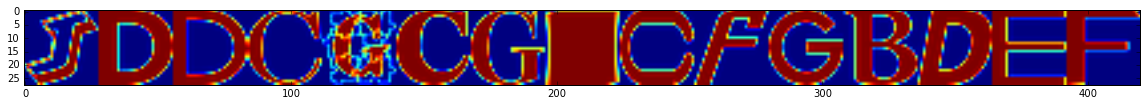

Label shape: (15, 10)
JDDCGCGICFGBDEF
With testing data
Image shape: (28, 280)


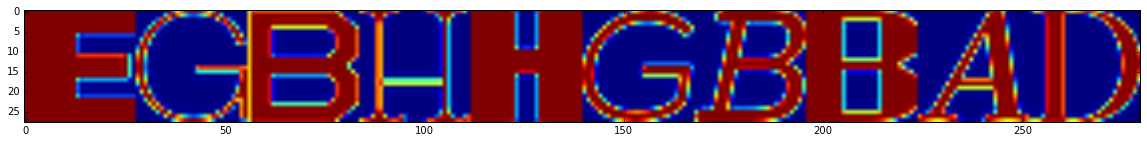

Label shape: (10, 10)
EGBHHGBBAD
Image shape: (28, 140)


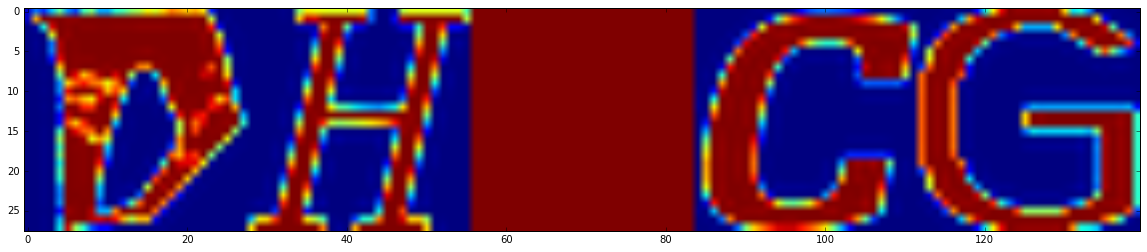

Label shape: (5, 10)
DHICG
Image shape: (28, 140)


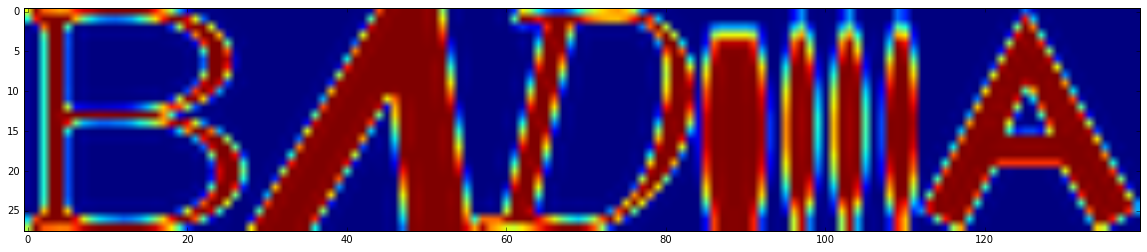

Label shape: (5, 10)
BADBA
Image shape: (28, 140)


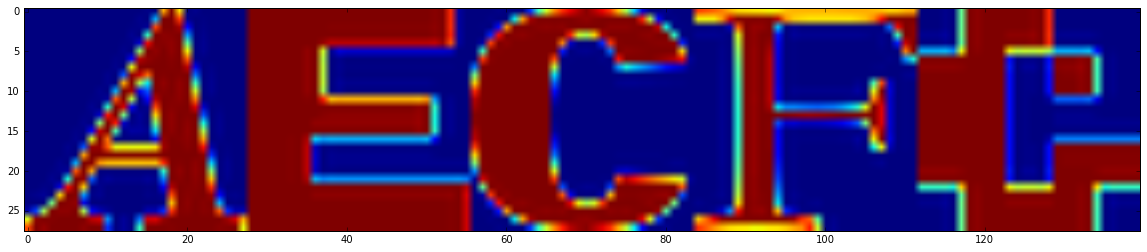

Label shape: (5, 10)
AECFC


In [5]:
# Create a sequence of digits from the training data
#
# returns (joined image, labels)
def create_sequence(train, labels, length=5):
    result_image = None
    result_labels = []    
    for a in range(length):
        # Choose random indexes for the digits
        index = np.random.randint(0, labels.shape[0])
        
        if result_image is None:
            result_image = train[index].copy()
        else:
            result_image = np.append(result_image, train[index], 1)
        
        result_labels.append(labels[index])

    return result_image, np.array(result_labels)
           
def show_image(data):
    print("Image shape:", data.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(data)
    plt.show()
    
def show_label(label):
    print("Label shape:", label.shape)
    result = ''
    for a in label:
        index = np.argmax(a)
        result += chr(ord('A') + index)
    print(result)
    
print("With training data")
image, label = create_sequence(train_dataset, train_labels, length=15)
show_image(image)
show_label(label)

print("With testing data")
image, label = create_sequence(test_dataset, test_labels, length=10)
show_image(image)
show_label(label)

# Create a batch of images and labels
def generate_batch(data, labels, size, length, **kwargs):    
    images, labels = zip(*[create_sequence(data, labels, length, **kwargs) for i in range(size)])
        
    result_images = np.array(images)
    result_labels = np.array(labels)
    
    return result_images, result_labels

images, labels = generate_batch(train_dataset, train_labels, 3, 5)

for i in range(len(labels)):
    show_image(images[i])
    show_label(labels[i])

Validation shape: (10000, 28, 140) (10000, 5, 10)
Testing shape: (10000, 28, 140) (10000, 5, 10)
Image shape: (28, 140)


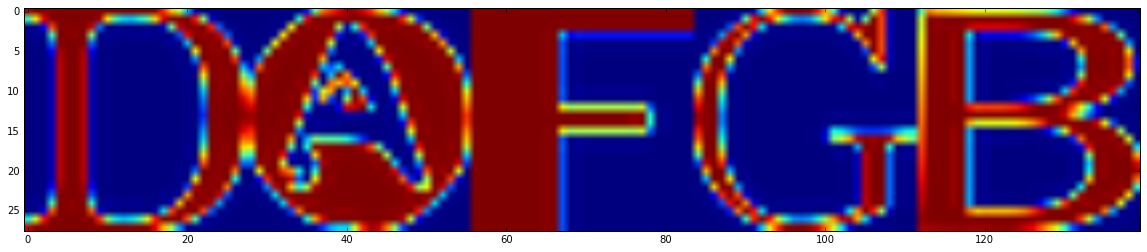

Label shape: (5, 10)
DAFGB
Image shape: (28, 140)


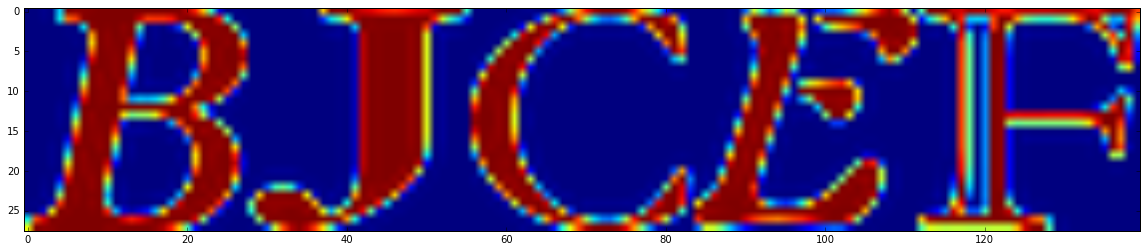

Label shape: (5, 10)
BJCEF


In [6]:
# Lets create our training, validation and testing datasets
num_digits = 5

#train_dataset_imgs, train_dataset_labels = generate_batch(train_dataset, train_labels, 200000, num_digits)
valid_dataset_imgs, valid_dataset_labels = generate_batch(valid_dataset, valid_labels, 1000, num_digits)
test_dataset_imgs, test_dataset_labels = generate_batch(test_dataset, test_labels, 10000, num_digits)

#print("Training shape:", train_dataset_imgs.shape, train_dataset_labels.shape)
print("Validation shape:", valid_dataset_imgs.shape, valid_dataset_labels.shape)
print("Testing shape:", test_dataset_imgs.shape, test_dataset_labels.shape)


show_image(valid_dataset_imgs[110])
show_label(valid_dataset_labels[110])
show_image(test_dataset_imgs[110])
show_label(test_dataset_labels[110])

In [7]:
# NN Helpers

# Create weights and biases
def new_wb(dimensions):
    """Create weights and biases bases on the first 2 dimensions"""
    weights = tf.Variable(tf.truncated_normal(dimensions))
    biases = tf.Variable(tf.truncated_normal(dimensions[1:]))
    return weights, biases

# Create a list of weights biases
def create_weights(dimensions):
    """Create a list of tuples like [(weights, biases), (weights, biases), ..]"""
    result = []
    for i in range(len(dimensions) -1):
        result.append(new_wb(dimensions[i:i+2]))
    return result

def create_nn(tensor_input, weights, modifiers=None):    
    """Create nn using weights and modifiers. By default creates y=x.w+b 
    
    Layers is a list of modifiers, one for each layer such as
           layers_train = [
               [tf.nn.relu, lambda x: tf.nn.dropout(x, 0.5)], # Use this in layer 1
               [],
           ]
    """
    if modifiers is not None:
        if len(weights) <> len(modifiers):
            raise Exception("Weights and layers must be the same size")
                
    for i in range(len(weights)):
        
        # Get the weights and biases from the array
        w, b = weights[i]
        
        # (x * weights + biases)
        new_layer = tf.add(tf.matmul(tensor_input, w), b) 
        
        # Run the modifiers, like relu...
        if modifiers is not None:
            for modifier in modifiers[i]:
                new_layer = modifier(new_layer)
            
        # This will be the input fo the next layer
        tensor_input = new_layer
    return tensor_input

def create_multi_output_nn(tf_input, count, weight_dims, modifiers=None):
    """Create multiple output tensors
    
    returns
        weights : list of (weights, biases) : the weights that were created
        tensors : list of Tensor : the tensors that were created
    """
    weights = [
        create_weights(weight_dims)
        for i in range(count)
    ]
    tf_output = [
        create_nn(tf_input, weights[i], modifiers)
        for i in range(count)
    ]

    return weights, tf_output


In [8]:
batch_size = 128
input_size = valid_dataset_imgs.shape[1] * valid_dataset_imgs.shape[2]

graph = tf.Graph()
with graph.as_default():
    
    #
    # Create the input image placeholder
    #
    tf_input = tf.placeholder(tf.float32, shape=(batch_size, input_size), name="b_input")
    
    
    
    #
    # Create the input nn
    #
        
    # The weights for out main net
    weights_main_dims = [
        input_size,  # Image input size
        1000  # main output
    ]
    
    # The weights for out main net
    weights_main = create_weights(weights_main_dims)
    
    # The main net
    tf_main = create_nn(tf_input, weights_main)
    

    
    
    #
    # Create the output classifiers, one for each digit
    #
        
    # Create multi output classifiers
    weights_outputs, tf_outputs = create_multi_output_nn(
        tf_main,
        num_digits,
        [weights_main_dims[-1], 10]
    )
    
    
    
    #
    # Create the labels, one for each digit
    #
    tf_train_labels = [
        tf.placeholder(tf.float32, shape=(batch_size, 10), name='b_label_%s' % i)
        for i in range(num_digits)
    ]
        
        
        
    #
    # Create the loss function
    #
    loss_fully_connected = [
        tf.nn.softmax_cross_entropy_with_logits(
            tf_outputs[i],
            tf_train_labels[i]
        )
        for i in range(num_digits)]
    loss = tf.reduce_mean(loss_fully_connected)
    
    
    
    #
    # Create the optimizer
    #
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    



    #
    # Create a predictor for the training set
    #
    graph_train_prediction = [
        tf.nn.softmax(tf_outputs[i])
        for i in range(num_digits)
    ]

    
    #
    # Create a predictor for the validation set
    #
    tf_valid_dataset = tf.constant(np.reshape(valid_dataset_imgs, [valid_dataset_imgs.shape[0], -1]))
    # validation tensor
    graph_valid_prediction = [
        tf.nn.softmax(
            create_nn(
                create_nn(tf_valid_dataset, weights_main), # The main graph with validation input
                weights_outputs[i]
            )
        )
        for i in range(num_digits)]

    
    
    #
    # Create a predictor for the test set
    #
    tf_test_dataset = tf.constant(np.reshape(test_dataset_imgs, [test_dataset_imgs.shape[0], -1]))
    # Test tensor
    graph_test_prediction = [
        tf.nn.softmax(
            create_nn(
                create_nn(tf_test_dataset, weights_main), # The main graph with test input
                weights_outputs[i]
            )
        )
        for i in range(num_digits)]


In [9]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

num_steps = 501

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):

        #
        # Generate a minibatch.
        #
        # Tese batches will always be random
        batch_data, batch_labels = generate_batch(train_dataset, train_labels, batch_size, num_digits)

        
        #
        # Ensure the feed_dict is loaded up correctly
        #
        
        feed_dict = {}
        
        # Add the input batch to the feed_dict
        feed_dict[tf_input] = np.reshape(batch_data, [batch_data.shape[0], -1])
        
        # Add the labels to the correct output tensors
        for i in range(num_digits):
            output_tensor = tf_train_labels[i]
            output_labels = batch_labels[:, i, :]
            feed_dict[output_tensor] = output_labels


            
        #
        # Create the graphs we want to execute and run :-)
        #
        fetches = [optimizer, loss] + graph_train_prediction
        result = session.run(fetches, feed_dict=feed_dict)    


        #
        # Check our stats
        #
        if (step % 100 == 0):
            print("Minibatch loss at step %d: %f" % (step, result[1]))
            train_predictions = result[2:]

            # Lets compare the train predictions
            train_accuracy = np.mean([
                    accuracy(train_predictions[i], batch_labels[:, i, :])
                    for i in range(num_digits)
                ])

            valid_accuracy = np.mean([
                    accuracy(graph_valid_prediction[i].eval(), valid_dataset_labels[:, i, :])
                    for i in range(num_digits)
                ])

            print("Minibatch accuracy: %.1f%%" % train_accuracy)
            print("Validation accuracy: %.1f%%" % valid_accuracy)

    #
    # How did we do on the test set?
    #
    test_accuracy = np.mean([
            accuracy(graph_test_prediction[i].eval(), test_dataset_labels[:, i, :])
            for i in range(num_digits)
        ])
    print("Test accuracy: %.1f%%" % test_accuracy)

Initialized
Minibatch loss at step 0: 1024.901978
Minibatch accuracy: 10.6%
Validation accuracy: 20.3%
Minibatch loss at step 100: 214.634674
Minibatch accuracy: 69.2%
Validation accuracy: 69.6%
Minibatch loss at step 200: 159.740265
Minibatch accuracy: 72.0%
Validation accuracy: 70.7%
Minibatch loss at step 300: 119.118507
Minibatch accuracy: 72.2%
Validation accuracy: 70.4%
Minibatch loss at step 400: 101.435898
Minibatch accuracy: 73.1%
Validation accuracy: 70.5%
Minibatch loss at step 500: 86.117950
Minibatch accuracy: 70.8%
Validation accuracy: 70.6%
Test accuracy: 77.6%
